In [4]:
import sys
sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from sklearn import datasets

from dal_toolbox.models.utils.random_features import RandomFeatureGaussianProcess
from dal_toolbox.models.utils.spectral_normalization import spectral_norm_linear

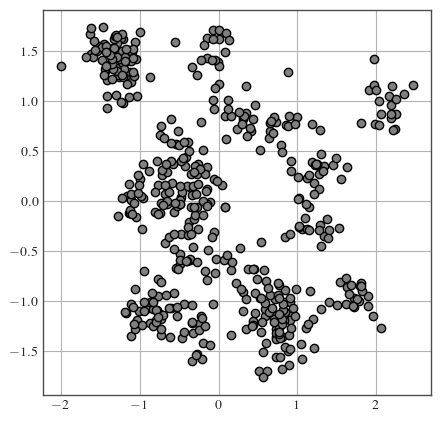

In [58]:
X, y = datasets.make_blobs([20 for i in range(25)], random_state=42)
# X, y = datasets.make_moons(200, noise=.1, random_state=42)
y %= 2
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c='gray')
plt.show()

In [59]:
class Model(nn.Module):
    def __init__(self,
                 num_classes: int,
                 use_spectral_norm: bool = True,
                 spectral_norm_params: dict = {},
                 gp_params: dict = {},
                 n_residual_layers: int = 6,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        def linear_layer(*args, **kwargs):
            if use_spectral_norm:
                return spectral_norm_linear(nn.Linear(*args, **kwargs), **spectral_norm_params)
            else:
                return nn.Linear(*args, **kwargs)

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList([linear_layer(128, 128) for _ in range(n_residual_layers)])
        self.last = RandomFeatureGaussianProcess(in_features=feature_dim, out_features=num_classes, **gp_params)
        self.act = nn.ReLU()
    

    def forward(self, x, mean_field=False, return_cov=False, return_random_features=False):
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x) + x)

        if mean_field:
            out = self.last.forward_mean_field(x)
        elif return_random_features:
            out = self.last(x, return_random_features=True)
        else:
            out = self.last(x, return_cov=return_cov)

        return out

In [60]:
class Model(nn.Module):
    def __init__(self,
                 num_classes: int,
                 use_spectral_norm: bool = True,
                 spectral_norm_params: dict = {},
                 gp_params: dict = {},
                 n_residual_layers: int = 6,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        def linear_layer(*args, **kwargs):
            if use_spectral_norm:
                return spectral_norm_linear(nn.Linear(*args, **kwargs), **spectral_norm_params)
            else:
                return nn.Linear(*args, **kwargs)

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList([linear_layer(128, 128) for _ in range(n_residual_layers)])
        self.last = RandomFeatureGaussianProcess(in_features=feature_dim, out_features=num_classes, **gp_params)
        self.act = nn.ReLU()
    

    def forward(self, x, mean_field=False, return_cov=False, return_random_features=False):
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x) + x)

        if mean_field:
            out = self.last.forward_mean_field(x)
        elif return_random_features:
            out = self.last(x, return_random_features=True)
        else:
            out = self.last(x, return_cov=return_cov)

        return out

    def get_logits(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for samples, _, indices in dataloader:
            logits = self(samples.to(device), mean_field=True)
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        return logits

In [96]:
def dataset_to_xy(dataset):
    X, y = [], []
    for batch in dataset:
        X.append(batch[0])
        y.append(batch[1])
    X = torch.stack(X).float()
    y = torch.Tensor(y).long()
    return X, y

@torch.no_grad()
def plot_contour(model, dataset, unlabeled_indices, labeled_indices, ax=None):
    X, y = dataset_to_xy(dataset)
    plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], c='gray', s=10, zorder=1, edgecolors='none')
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=150, marker='x', linewidths=5)

    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    domain = np.abs(np.array([plt.ylim(), plt.xlim()])).flatten().max()
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
    logits = model(zz, mean_field=True)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=183, train_loss=0.00307]         

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 83.23it/s, v_num=183, train_loss=1.69e-5]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 76.06it/s, v_num=183, train_loss=1.69e-5]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


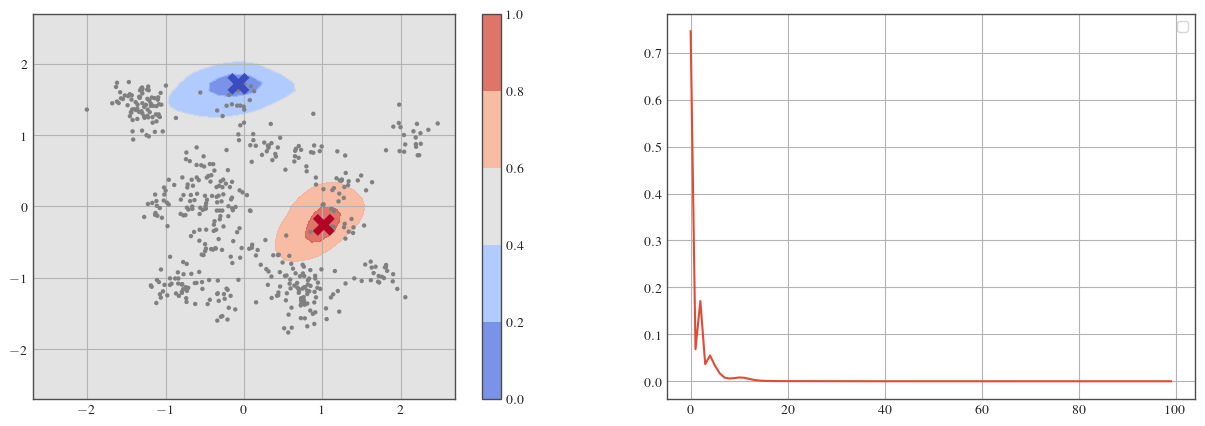

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 93.36it/s, v_num=184, train_loss=3.59e-5]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 82.73it/s, v_num=184, train_loss=3.59e-5]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


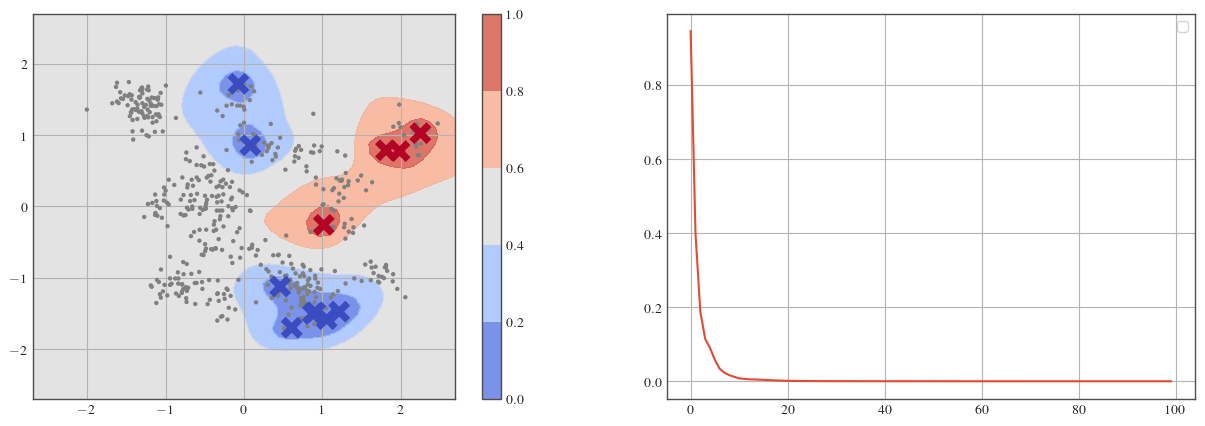

In [97]:
from dal_toolbox.models.sngp import SNGPModel
from dal_toolbox.models.utils.callbacks import MetricHistory

from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import EntropySampling

spectral_norm_params = dict(
    norm_bound=.9,
    n_power_iterations=1
)
gp_params = dict(
    num_inducing=1024,
    kernel_scale=0.05,
    random_feature_type='orf',
    scale_random_features=False,
)
epochs = 100
n_cycles = 2
acq_size = 10

torch.manual_seed(0)
al_datamodule = ActiveLearningDataModule(train_ds, train_batch_size=32)
al_datamodule.random_init(2, class_balanced=True)
al_strat = EntropySampling()

model = Model(num_classes=2, use_spectral_norm=True, spectral_norm_params=spectral_norm_params, gp_params=gp_params)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-3, momentum=.9)
model = SNGPModel( model, optimizer=optimizer)

for i_cycle in range(n_cycles):
    if i_cycle != 0:
        indices = al_strat.query(model=model, al_datamodule=al_datamodule, acq_size=acq_size)
        al_datamodule.update_annotations(indices)

    model.reset_states()
    history = MetricHistory()
    trainer = L.Trainer(max_epochs=epochs, callbacks=[history], enable_model_summary=False, enable_checkpointing=False)
    trainer.fit(model, al_datamodule)

    plt.figure(figsize=(15, 5))
    plt.subplot(122)
    plt.plot([d[f'train_loss'] for d in history])
    plt.legend()
    plot_contour(model, al_datamodule.query_dataset, al_datamodule.unlabeled_indices, al_datamodule.labeled_indices, ax=plt.subplot(121))
    plt.show()